In [1]:
import time
from matplotlib import pyplot as plt
import numpy as np
import pyvisa as visa
import pickle
from tqdm import tqdm
from mcculw import ul
import nidaqmx
from typing import Tuple
import datetime
import pandas as pd

In [2]:
np.set_printoptions(threshold=8)

def set_osc_acq(osc):
    # Configuración de la adquisición de curvas
    osc.write('DAT:ENC RPB')
    osc.write('DAT:WID 1')
    osc.write('DAT:STAR 1')
    osc.write('DAT:STOP 2500')
    osc.write('ACQ:MOD SAMP')

def parse_parameters(wfmp_params):
    """Parsea la información de configuración de las escalas y las almacena en un diccionario.
    Para después simplificar el gráfico de la curva."""
    result = {}
    header_def = [('BYT_Nr', int),
              ('BiT_Nr', int),
              ('ENCdg', str),
              ('BN_Fmt', str),
              ('BYT_Or', str)]
    wfrm1_def = [('WFID', str),
             ('NR_PT', int),
             ('PT_FMT', str),
             ('XUNIT', str),
             ('XINCR', float),
             ('PT_Off', int),
             ('YUNIT', str),
             ('YMULT', float),
             ('YOFf', float),
             ('YZEro', float)]

    full_def = header_def + [(f'wfm1:{k}', c) for k, c in wfrm1_def] \
           + [(f'wfm2:{k}', c) for k, c in wfrm1_def] \
           + [(f'wfm3:{k}', c) for k, c in wfrm1_def] \
           + [(f'wfm4:{k}', c) for k, c in wfrm1_def]
    for (key, conversor), param in zip(full_def, wfmp_params.split(';')):
        result[key] = conversor(param)
    return result

def escalar_curva(data, parametros):
    """Devuelve el par de vectores (t, v) a partir de la curva levantada del osciloscopio
    y los parámetros de escala del mismo. El eje temporal está en ms y el vertical en Volts/"""
    n = len(data)
    t = 1e3 * (np.arange(n) - parametros['wfm1:PT_Off']) * parametros['wfm1:XINCR']

    v = (data - parametros['wfm1:YOFf']) * parametros['wfm1:YMULT'] \
                    + parametros['wfm1:YZEro']
    return t, v


# Definimos una función para obtener los datos de uno de los canales del osciloscopio
def medir_canal(osc, channel):
    osc.write(f'DAT:SOU CH{channel}') # Adquirimos del canal 
    # La lectura se puede hacer en modo binario, lo que la hace más eficiente
    conf_parameters = parse_parameters(osc.query('WFMP?'))
    data = osc.query_binary_values('CURV?', datatype='B', container=np.array)
    
    # Escalamos los valores con las unidades correctas
    t, v = escalar_curva(data, conf_parameters)
    return t, v

In [3]:
#%%
# inicializo comunicacion con equipos
rm = visa.ResourceManager()

# lista de dispositivos conectados, para ver las id de los equipos
print(rm.list_resources())

('GPIB0::1::INSTR', 'GPIB0::7::INSTR')


In [4]:
# Abrimos el recurso de VISA, en este caso es un osciloscopio
osc = rm.open_resource('GPIB0::7::INSTR')

print(osc.query("HOR?"))
set_osc_acq(osc)

func = rm.open_resource("GPIB0::1::INSTR")

MAIN;1000;5.3E1;1.0E-1;50;1.0E-1;RUNSAFTER;2.5E-9;1.0065E-6;LOCK;LOCK;0



In [5]:
def guardar_dict(dic: dict, path: str) -> None:
    # Guardamos los datos en un .pickle
    pickle.dump(dic, open(f'{path}.pickle', 'wb'))
    return
    
def barrido(func_init_param: dict, 
            param_tuple: tuple, 
            rango: np.ndarray,
            scale_change = False) -> dict:

    # Ponemos los parámetros iniciales del generador de funciones
    for param, value in zip(func_init_param.keys(), func_init_param.values()):
        if param == "AMPL":
            func.write(f"{param} {value} VP")
        else:
            func.write(f"{param} {value}")

    # Creamos un diccionario para guardar las mediciones que tomamos
    dic = {}
    # Parámetro y unidad de lo que se barre
    param = param_tuple[0]
    unit = param_tuple[1]

    for i, value in tqdm(enumerate(rango)):
        # Cambiamos la amplitud de la señal en voltaje pico a pico
        func.write(f"{param} {value} VP")
        print(f"{param} cambio a {value} {unit}")
        
        # Cambiamos el trigger al valor medio de la señal del canal 1, que es una onda cuadrada
        osc.write("TRIGGER:MAIN SetLevel")
        time.sleep(4)
        
        if scale_change:
            # Usamos los valores de la anterior medición para cambiar la escala y la posición vertical de la siguiente
            if i >= 1:
                print(1)
                # Cambiamos la posicion vertical de los canales
                #for ch in [1,2]:
                    #if ch == 1:
                # Cambiamos la escala del canal 1
                #scale = (2*amp/2)-(2*amp/2)%0.005
                #osc.write(f'CH1:SCALE {scale}')
                #osc.write("TRIGGER:MAIN SetLevel")
                # Cambiamos la posición vertical de las señales
                # La posición se selecciona eligiendo los cuadrados del osciloscopio
                #osc.write(f"CH1:POSition {correccion_posicion/scale}")
                        
                    #else:
                    #  scale = 0.05 # 50 mV
        
    # Tomamos mediciones de los canales
    t_1, v_1 = medir_canal(osc,1)
    t_2, v_2 = medir_canal(osc,2)
    
    # Guardamos los datos
    dic[f"{value}{unit}"] = {"t_1":t_1, "V_1":v_1, "t_2":t_2, "V_2": v_2}
    
    return dic

In [26]:
func_init_param = {"OFFS" : -2, "FREQ": 0, "AMPL" : 0, "FUNC": 0}

magnitud = ("OFFS", "V")

rango = [0]

dic = barrido(func_init_param, magnitud, rango)

0it [00:00, ?it/s]

OFFS cambio a 0 V


1it [00:04,  4.01s/it]


# Celda para modificar directamente atributos del generador de funciones

In [7]:
# Para enviar una cuadrada es 1, 0 para sinusoidal
func.write("FUNC 0")
# Amplitud de la señal
func.write("AMPL 0 VP") # En formato "AMP {valor_amplitud} {unidad, ej: VP:VPP, VR:VRMS}"
# Offset de la señal
func.write("OFFS 1.5")
# Frecuencia de la señal 
func.write("FREQ 10000")
# escala temporal
#osc.write(f'HOR:SCA 0.005')

12

# Medición única

In [12]:
# Parámetros
amp = 0
freq = 1000
offset = 2

# Amplitud de la señal
func.write(f"AMPL {amp} VP") # En formato "AMP {valor_amplitud} {unidad, ej: VP:VPP, VR:VRMS}"
# Offset de la señal
func.write(f"OFFS {offset}")
# Frecuencia de la señal
func.write(f"FREQ {freq}")

# Escala de tiempo del osciloscopio
#osc.write(f'HOR:SCA 0.0000025')

11

In [24]:
t_1, v_1 = medir_canal(osc,1)
t_2, v_2 = medir_canal(osc,2)

# Guardamos los datos para pickle
dic = {}
dic[f"{offset}V"] = {"t_1":t_1, "V_1":v_1, "t_2":t_2, "V_2": v_2}

NameError: name 'pd' is not defined

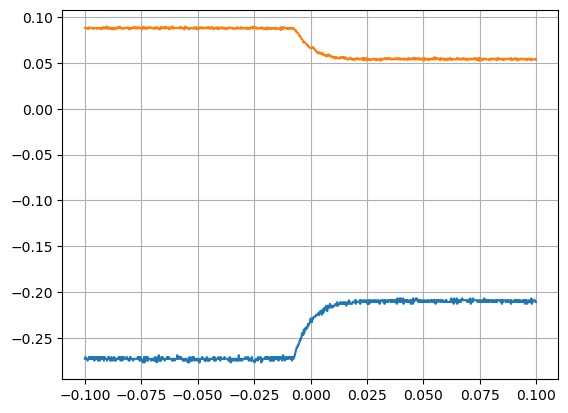

In [145]:
plt.plot(dic[f"{offset}V"]["t_1"],dic[f"{offset}V"]["V_1"])
plt.plot(dic[f"{offset}V"]["t_2"],dic[f"{offset}V"]["V_2"])
plt.grid()
plt.show()

In [147]:
# Guardamos los datos en un .pickle
pickle.dump(dic, open(f'../mediciones/D.D/Tiempo de respuesta del laser/T_rta {freq} kHz {amp} Amp {offset} OFFS 10 us.pickle', 'wb'))

# Medición en el tiempo

In [13]:
# Parámetros
amp = 0
freq = 0
offset = 1.4

# Amplitud de la señal
func.write(f"AMPL {amp} VP") # En formato "AMP {valor_amplitud} {unidad, ej: VP:VPP, VR:VRMS}"
# Offset de la señal
func.write(f"OFFS {offset}")
# Frecuencia de la señal
func.write(f"FREQ {freq}")

# Escala de tiempo del osciloscopio
# osc.write(f'HOR:SCA 0.1')

8

In [14]:
t_scale = float(osc.query(f'HOR:SCA?')[:-1])

offsets = np.arange(1.4,2.4, 0.2)

keys = ["t_1", "t_2", "V_1", "V_2"]
# Guardamos los datos para pickle

dic = {}

for offset in offsets:
    # Offset de la señal
    func.write(f"OFFS {offset}")
    time.sleep(5)
    params = {"offset": offset, "t_scale": t_scale}
    dic["params"] = params

    t0 = time.time()

    for i in range(23): # Cada medición dura 2.7 s así que 23 mediciones son casi 1 minuto
        
        t_i = time.time()-t0 # Inicio de la medición
        
        t_1, v_1 = medir_canal(osc,1)
        t_2, v_2 = medir_canal(osc,2)

        # dic["t_1"] += t_1
        # dic["V_1"] += v_1
        # dic["t_2"] += t_2
        # dic["V_2"] += v_2
        
        t_f = time.time()-t0 # Final de la medición
        dic[i] = {"t_1":t_1, "V_1":v_1, "t_2":t_2, "V_2": v_2, "tupla_t" : (t_i, t_f)}
        
        time.sleep(2)
    
    path = f'../mediciones/D.D/Medicion laser continua/R = 50/con polarizador {offset} V'
    guardar_dict(dic, path)

C:\Users\nicof\AppData\Local\Temp\ipykernel_4076\288219888.py:3: ResourceWarning: unclosed file <_io.BufferedWriter name='../mediciones/D.D/Medicion laser continua/R = 50/con polarizador 1.4 V.pickle'>
  pickle.dump(dic, open(f'{path}.pickle', 'wb'))
C:\Users\nicof\AppData\Local\Temp\ipykernel_4076\288219888.py:3: ResourceWarning: unclosed file <_io.BufferedWriter name='../mediciones/D.D/Medicion laser continua/R = 50/con polarizador 1.5999999999999999 V.pickle'>
  pickle.dump(dic, open(f'{path}.pickle', 'wb'))
C:\Users\nicof\AppData\Local\Temp\ipykernel_4076\288219888.py:3: ResourceWarning: unclosed file <_io.BufferedWriter name='../mediciones/D.D/Medicion laser continua/R = 50/con polarizador 1.7999999999999998 V.pickle'>
  pickle.dump(dic, open(f'{path}.pickle', 'wb'))


KeyboardInterrupt: 

In [164]:
offset = 1
func.write(f"OFFS {offset}")

8

In [171]:
offset = 1
func.write(f"OFFS {offset}")
time.sleep(2)
t_1, v_1 = medir_canal(osc,1)
t_2, v_2 = medir_canal(osc,2)
offset = 2
func.write(f"OFFS {offset}")
time.sleep(2)
t_1, v_1 = medir_canal(osc,1)
t_2, v_2 = medir_canal(osc,2)


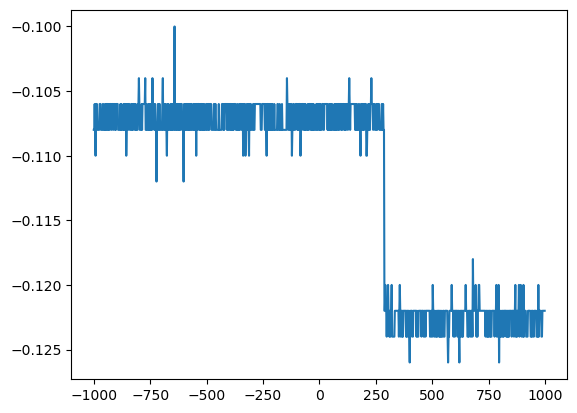

In [139]:
plt.plot(dic[20]["t_1"], dic[20]["V_1"])

# Barrido en amplitud

In [18]:
# Offset de la señal
offset = -2
correccion_posicion = -2*offset
func.write(f"OFFS {offset}")

# Valores de amplitud que tomará la señal
amp_values = np.linspace(0.1,2,20)
# Creamos un diccionario para guardar las mediciones que tomamos
dic = {}

for i, amp in tqdm(enumerate(amp_values)):
    # Cambiamos la amplitud de la señal en voltaje pico a pico
    func.write(f"AMPL {amp} VP")
    print(f"La amplitud cambio a {amp} V")
    # Cambiamos el trigger al valor medio de la señal del canal 1, que es una onda cuadrada
    osc.write("TRIGGER:MAIN SetLevel")
    time.sleep(4)
    
    # Usamos los valores de la anterior medición para cambiar la escala y la posición vertical de la siguiente
    if i >= 1:
        # Cambiamos la posicion vertical de los canales
        #for ch in [1,2]:
            #if ch == 1:
        # Cambiamos la escala del canal 1
        #scale = (2*amp/2)-(2*amp/2)%0.005
        #osc.write(f'CH1:SCALE {scale}')
        #osc.write("TRIGGER:MAIN SetLevel")
        # Cambiamos la posición vertical de las señales
        # La posición se selecciona eligiendo los cuadrados del osciloscopio
        #osc.write(f"CH1:POSition {correccion_posicion/scale}")
                
            #else:
              #  scale = 0.05 # 50 mV
        
    # Tomamos mediciones de los canales
    t_1, v_1 = medir_canal(osc,1)
    t_2, v_2 = medir_canal(osc,2)
    
    # Evitamos medir tensiones positivas, ya que sabemos que el laser funciona con corr < 0
    if np.mean(v_2) > 0:
        print("Medí positivo")
    #    break
    
    # Guardamos los datos
    dic[f"{amp}V"] = {"t_1":t_1, "V_1":v_1, "t_2":t_2, "V_2": v_2}


0it [00:00, ?it/s]

La amplitud cambio a 0.1 V


1it [00:07,  7.02s/it]

La amplitud cambio a 0.2 V


1it [00:11, 11.03s/it]


NameError: name 'scale' is not defined

In [303]:
# Guardamos los datos en un .pickle
pickle.dump(dic, open(f'../mediciones/Barrido en amplitud a {offset} V de offset.pickle', 'wb'))

# Barrido en offset

In [48]:
func.write(f"OFFS -1")
func.write(f"AMPL 1 VP")
func.write(f"FREQ 1000")
osc.write("TRIGGER:MAIN SetLevel")

23

In [199]:
scale_1 = f'{(2*amp/2)-(2*amp/2)%0.005}'
osc.write(f'CH1:SCALE {scale_1}')
osc.write("TRIGGER:MAIN SetLevel")

23

In [178]:
"En este encontramos que se rompe"
2.9473684210526314 

2.9473684210526314

In [161]:
# Lista con los valores de offset a barrer
offs_values = np.linspace(0, 3.2, 20)


# Amplitud de la señal
amp = 0
func.write(f"AMPL {amp} VP") # En formato "AMP {valor_amplitud} {unidad, ej: VP:VPP, VR:VRMS}"
# Cambiamos la escala del canal 1
scale_1 = 0.02
osc.write(f'CH1:SCALE {scale_1}')
scale_2 = 0.05
osc.write(f'CH2:SCALE {scale_2}')
# Diccionario para guardar las mediciones
dic = {}

# time.sleep(?)
t_sleep = 5

for i, offset in tqdm(enumerate(offs_values)):
    # Cambiamos el offset de la señal
    func.write(f"OFFS {offset}")
    print(f"El offset cambio a {offset} V")
    
    # Cambiamos el trigger al valor medio de la señal del canal 1, que es una onda cuadrada
    osc.write("TRIGGER:MAIN SetLevel")
    time.sleep(t_sleep)
    
    # Usamos los valores de la anterior medición para cambiar la escala y la posición vertical de la siguiente
    if i >= 1:
        # Cambiamos la posicion vertical de los canales
        for ch in [1,2]:
            if ch == 1:
                # Cambiamos la escala del canal 1
                scale = (2*offset/3)-(2*offset/3)%0.005
                osc.write(f'CH{ch}:SCALE {scale}')

            else:
                scale = 0.05 # 50 mV
                    
                # Cambiamos la posición vertical de las señales
                offset_anterior = np.mean(dic[f"{offs_values[i-1]}V"][f"V_{ch}"])
                correccion_posicion = -(offset_anterior-offset_anterior%0.005) 
                # La posición se selecciona eligiendo los cuadrados del osciloscopio
                osc.write(f"CH{ch}:POSition {correccion_posicion/scale}")
        
    time.sleep(t_sleep)
    # Tomamos mediciones de los canales
    t_1, v_1 = medir_canal(osc,1)
    t_2, v_2 = medir_canal(osc,2)
    
    # Evitamos medir tensiones positivas, ya que sabemos que el 
    if np.mean(v_2) > 0:
        print("Medí positivo")
    #    break
    
    # Guardamos los datos
    dic[f"{offset}V"] = {"t_1":t_1, "V_1":v_1, "t_2":t_2, "V_2": v_2}


func.write(f"OFFS {offs_values[0]}")

0it [00:00, ?it/s]

El offset cambio a 0.0 V


1it [00:12, 12.71s/it]

Medí positivo
El offset cambio a 0.16842105263157894 V


1it [00:22, 22.73s/it]


KeyboardInterrupt: 

In [17]:
# Guardamos los datos en un .pickle
pickle.dump(dic, open(f'../mediciones/D.D/Barrido continua a {amp} V de amp sobre R.pickle', 'wb'))

# Barrido en frecuencias

In [64]:
# configuramos una sinusoidal
func.write("FUNC 0") # 1 Cuadrada, 0 para el seno
# Seteamos el offset
offset = 1.3
func.write(f'OFFS {offset}')

# Seteamos la amplitud 
amp = 0.1
func.write(f'AMPL {amp} VP')

# func.write('OUTE1')
freq = 1
func.write(f'FREQ {freq}')
# osc.write(f'HOR:SCA 0.05')

8

In [65]:
freq_list = np.logspace(0, 5, 30)
df = freq_list[1]-freq_list[0]

#R paralela al fotodiodo
R = 1000

# Diccionario para guardar las mediciones
dic = {}

# time.sleep(?)
t_sleep = 3

for i,freq in tqdm(enumerate(freq_list)):
    
    func.write(f"FREQ {freq}")
    print(f"La frecuencia cambió a {freq}")
    
    # cambiamos la escala temporal
    t = 1/freq # un periodo
    osc.write(f'HOR:SCA {t/2}') # en segundos
    
    if i >= 1:
        # amp1 = np.max(v_1) - np.min(v_1)
        # scale_1 = (2*amp1/8)-(2*amp1/8)%0.005
        # osc.write(f'CH1:SCALE {scale_1}')
        amp2 = np.max(v_2) - np.min(v_2)
        scale_2 = 0.025 # mV #(2*amp2/7)-(2*amp2/7)%0.005
        #osc.write(f'CH2:SCALE {scale_2}')

        # # Cambiamos la posición vertical de las señales
        # offset_anterior = np.mean(dic[f"{freq_list[i-1]}Hz"][f"V_2"])
        # correccion_posicion = -(offset_anterior-offset_anterior%0.005) 
        # La posición se selecciona eligiendo los cuadrados del osciloscopio
        osc.write(f"CH2:POSition {-3}")


    time.sleep(t_sleep)
    
    osc.write('CH1:SCA?')  # Send SCPI command to query Channel 1's voltage scale
    scale_1 = float(osc.read())  # Read the response from the oscilloscope
    osc.write('CH2:SCA?')  # Send SCPI command to query Channel 2's voltage scale
    scale_2 = float(osc.read())  # Read the response from the oscilloscope

    scales = [scale_1,scale_2]
    # Tomamos mediciones de los canales
    t_1, v_1 = medir_canal(osc,1)
    t_2, v_2 = medir_canal(osc,2)
    
    # Guardamos los datos
    dic[f"{freq}Hz"] = {"t_1":t_1, "V_1":v_1, "t_2":t_2, "V_2": v_2, "scale": scales, 
                        "params": {'amp': amp, 'offset': offset},"R_fotodiodo":f"{R} Ohms"}

print("\n Terminó el barrido")

0it [00:00, ?it/s]

La frecuencia cambió a 1.0


1it [00:05,  5.85s/it]

La frecuencia cambió a 1.4873521072935114


2it [00:11,  5.95s/it]

La frecuencia cambió a 2.2122162910704493


3it [00:17,  5.95s/it]

La frecuencia cambió a 3.2903445623126686


4it [00:23,  5.97s/it]

La frecuencia cambió a 4.893900918477494


5it [00:29,  5.98s/it]

La frecuencia cambió a 7.278953843983151


6it [00:36,  6.06s/it]

La frecuencia cambió a 10.826367338740546


7it [00:42,  6.10s/it]

La frecuencia cambió a 16.102620275609393


8it [00:48,  6.11s/it]

La frecuencia cambió a 23.95026619987486


9it [00:54,  6.05s/it]

La frecuencia cambió a 35.622478902624444


10it [01:00,  6.05s/it]

La frecuencia cambió a 52.9831690628371


11it [01:06,  6.03s/it]

La frecuencia cambió a 78.80462815669912


12it [01:12,  6.04s/it]

La frecuencia cambió a 117.21022975334806


13it [01:18,  5.98s/it]

La frecuencia cambió a 174.3328822199989


14it [01:24,  6.02s/it]

La frecuencia cambió a 259.2943797404667


15it [01:30,  5.98s/it]

La frecuencia cambió a 385.6620421163472


16it [01:36,  5.99s/it]

La frecuencia cambió a 573.6152510448682


17it [01:42,  5.98s/it]

La frecuencia cambió a 853.1678524172814


18it [01:48,  6.00s/it]

La frecuencia cambió a 1268.9610031679233


19it [01:54,  6.00s/it]

La frecuencia cambió a 1887.3918221350978


20it [02:00,  6.01s/it]

La frecuencia cambió a 2807.2162039411787


21it [02:06,  6.01s/it]

La frecuencia cambió a 4175.318936560405


22it [02:12,  6.01s/it]

La frecuencia cambió a 6210.169418915616


23it [02:18,  5.98s/it]

La frecuencia cambió a 9236.708571873865


24it [02:24,  5.98s/it]

La frecuencia cambió a 13738.237958832638


25it [02:30,  5.97s/it]

La frecuencia cambió a 20433.59717856944


26it [02:36,  5.97s/it]

La frecuencia cambió a 30391.95382313201


27it [02:42,  5.98s/it]

La frecuencia cambió a 45203.5365636025


28it [02:48,  6.01s/it]

La frecuencia cambió a 67233.57536499335


29it [02:54,  5.98s/it]

La frecuencia cambió a 100000.0


30it [03:00,  6.00s/it]


 Terminó el barrido


In [66]:
# Guardamos los datos en un .pickle
pickle.dump(dic, open(f'../mediciones/D.D/Tiempo de respuesta del laser/Barrido sinusoidal 12-06 2.pickle', 'wb'))

C:\Users\nicof\AppData\Local\Temp\ipykernel_6100\2010323642.py:2: ResourceWarning: unclosed file <_io.BufferedWriter name='../mediciones/D.D/Tiempo de respuesta del laser/Barrido sinusoidal 12-06 2.pickle'>
  pickle.dump(dic, open(f'../mediciones/D.D/Tiempo de respuesta del laser/Barrido sinusoidal 12-06 2.pickle', 'wb'))


# Barrido en frecuencias con la DAQ

## Vieja DAQ

In [5]:
# Para obtener el descriptor de la DAQ
descriptor = ul.get_daq_device_inventory(1)[0] # 7 para ANY o 1 para USB
board_num = ul.get_board_number(descriptor)
print(descriptor)
print(board_num)

# Para iniciar la DAQ
DAQ = ul.create_daq_device(1, descriptor) 

[]


## Buena DAQ

In [92]:
def medir(duracion: float, fs: int, device_name: str, bounds = [0,10,0,10]) -> np.ndarray:
    """
    Medir un canal de la DAQ.

    Parametros:
        - duracion (float): Cantidad de segundos a medir.
        - fs (int): Cantidad de puntos por segundo.
        - device_name (str): Nombre de la DAQ conectada. Obtenible mediante
                             "nidaqmx.system.System.local().devices[0].name"
    """

    cant_puntos = duracion*fs # Tiempo a medir por cantidad de puntos por segundo

    # Configuraciones del canal de medicion
    terminal_config = nidaqmx.constants.TerminalConfiguration.RSE
    sample_mode = nidaqmx.constants.AcquisitionType.FINITE
    samples_per_channel = nidaqmx.constants.READ_ALL_AVAILABLE

    osc.write(f'HOR:SCA?')  # Send SCPI command to query the time scale
    osc_time_scale = float(osc.read())  # Read the response from the oscilloscope

    with nidaqmx.Task() as task:

        # Set voltage channel.
        task.ai_channels.add_ai_voltage_chan(f"{device_name}/ai1", 
                                             terminal_config = terminal_config, 
                                             max_val=bounds[1], 
                                             min_val=bounds[0])
        
        task.ai_channels.add_ai_voltage_chan(f"{device_name}/ai2",
                                             max_val=bounds[3],
                                             min_val=bounds[2])
        
        # Medir una cantidad de puntos.
        task.timing.cfg_samp_clk_timing(fs, 
                                        # samps_per_chan=cant_puntos, 
                                        sample_mode=sample_mode)
        t0 = time.time()
        datos = task.read(number_of_samples_per_channel=nidaqmx.constants.READ_ALL_AVAILABLE)           
        t1 = time.time()
        V_1 = datos[0]
        V_2 = datos[1]
        # print("%2.3fs %d %d %2.3f" % (t1-t0, len(datos), total, total/(t1-t0))) 

        
        datos = task.read(number_of_samples_per_channel=samples_per_channel)           
        T = np.linspace(0,8*osc_time_scale , len(datos[0]))
    return T, V_1, V_2

def medir_continuo(duracion: float = 5, 
                   fs: int = 300000, 
                   max_iter: int = 10,
                   bounds = [0,10,0,10]) -> Tuple[np.ndarray]:

    device_name = nidaqmx.system.System.local().devices[0].name

    tiempos, datos_y = [], []
    try:
        for i in tqdm(range(max_iter)):

            t_0 = time.perf_counter()

            y = medir(duracion, fs, device_name, bounds)
            
            datos_y = np.concatenate([datos_y, y])

            tiempos.append(time.perf_counter()-t_0)

            time.sleep(1)
    except KeyboardInterrupt:
        print("Deteniendo")
    return tiempos, datos_y

def save_file(datos_y: np.ndarray) -> None:

    muestra = input("Nombre de la muestra: ")
    date = datetime.datetime.now().strftime("%m-%d-%Y %H %M")
    file = f"{muestra} {date}.npz"

    np.savez_compressed(file, y=datos_y)

In [93]:
#para saber el ID de la placa conectada (DevX)
system = nidaqmx.system.System.local()
for device in system.devices: 
    print(device)

with nidaqmx.Task() as task:
    ai_channel = task.ai_channels.add_ai_voltage_chan("Dev2/ai1",max_val=10,min_val=-10)
    print(ai_channel.ai_term_cfg)    
    print(ai_channel.ai_max)
    print(ai_channel.ai_min)

Device(name=Dev2)
TerminalConfiguration.DIFF
10.0
-10.0


In [91]:
def medicion_continua(duracion, fs):
    cant_puntos = int(duracion*fs)
    with nidaqmx.Task() as task:
        modo= nidaqmx.constants.TerminalConfiguration.BAL_DIFF
        task.ai_channels.add_ai_voltage_chan("Dev2/ai1", terminal_config = modo,max_val=1.5,min_val=-1.5)
        task.ai_channels.add_ai_voltage_chan("Dev2/ai2", terminal_config = modo,max_val=4,min_val=0) 
        task.timing.cfg_samp_clk_timing(fs, sample_mode = nidaqmx.constants.AcquisitionType.CONTINUOUS)
        task.start()
        t0 = time.time()
        total = 0
        V_1 = []
        V_2 = []
       
        while total<cant_puntos:
            time.sleep(0.1)
            datos = task.read(number_of_samples_per_channel=nidaqmx.constants.READ_ALL_AVAILABLE)           
            total = total + len(datos[0])
            t1 = time.time()
            V_1= V_1 + datos[0]
            V_2 = V_2 + datos[1]
           # V_cupla = V_cupla + datos[2]
            print("%2.3fs %d %d %2.3f" % (t1-t0, len(datos), total, total/(t1-t0)))            
                
    return V_1, V_2

### Ojalá ande

In [99]:
# configuramos una sinusoidal
func.write("FUNC 0") # 1 Cuadrada, 0 para el seno
# Seteamos el offset
offset = 1.2
func.write(f'OFFS {offset}')

# Seteamos la amplitud 
amp = 0.3
func.write(f'AMPL {amp} VP')

# func.write('OUTE1')
freq = 10
func.write(f'FREQ {freq}')
# osc.write(f'HOR:SCA 0.05')

9

In [89]:
device_name = nidaqmx.system.System.local().devices[0].name
duracion = 8/freq
fs = 50000

dic = {}
T, V_1, V_2 = medir_continuo(duracion, fs, device_name, bounds = [-5,5,-5,5])

# Guardamos los datos
dic[f"{freq}Hz"] = {"t_1":T, "V_1":V_1, "t_2":T, "V_2": V_2,"params": {'amp': amp, 'offset': offset},"R_fotodiodo":"1000 Ohms"}

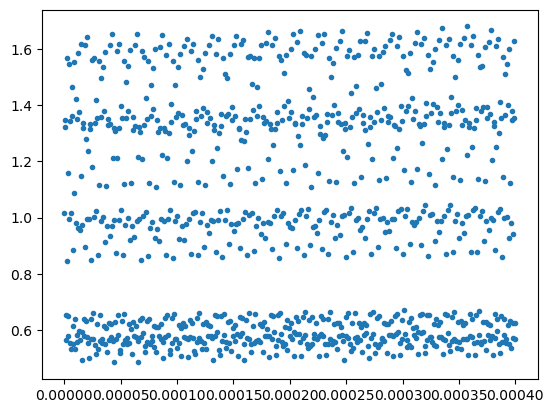

In [90]:
plt.plot(T,V_1,".")
plt.show()

In [ ]:
# Guardamos los datos en un .pickle
pickle.dump(dic, open(f'../mediciones/D.D/Tiempo de respuesta del laser/Barrido sinusoidal DAQ 08-06.pickle', 'wb'))

### No anda

In [12]:
def medicion_continua(duracion, fs, bounds_ch1 = [-1.5,1.5], bounds_ch2 = [-1.5,1.5]):
    cant_puntos = int(duracion*fs)
    with nidaqmx.Task() as task:
        # modo= nidaqmx.constants.TerminalConfiguration.BAL_DIFF # No funciono
        modo= nidaqmx.constants.TerminalConfiguration.DIFF
        task.ai_channels.add_ai_voltage_chan("Dev1/ai1",max_val=max(bounds_ch1),min_val=min(bounds_ch1))
        task.ai_channels.add_ai_voltage_chan("Dev1/ai3",max_val=max(bounds_ch2),min_val=min(bounds_ch2))
        task.timing.cfg_samp_clk_timing(fs, sample_mode = nidaqmx.constants.AcquisitionType.CONTINUOUS)
        task.start()
        t0 = time.time()
        total = 0
        T = []
        V_1, V_2 = [], []
        while total<cant_puntos:
            time.sleep(0.1)
            datos = task.read(number_of_samples_per_channel=nidaqmx.constants.READ_ALL_AVAILABLE)           
            total = total + len(datos[0])
            t1 = time.time()
            T.append(t1-t0)
            V_1 = V_1 + datos[0]
            V_2 = V_2 + datos[1]
            
            print("%2.3fs %d %d %2.3f" % (t1-t0, len(datos), total, total/(t1-t0)))            
        
        # Reset the task
        task.reset()
    return T, V_1, V_2     

In [14]:
# configuramos una sinusoidal
func.write("FUNC 0") # 1 Cuadrada, 0 para el seno
# Seteamos el offset
offset = 2
func.write(f'OFFS {offset}')

# Seteamos la amplitud 
amp = 0.5
func.write(f'AMPL {amp} VP')

# func.write('OUTE1')
freq = 10
func.write(f'FREQ {freq}')
# osc.write(f'HOR:SCA 0.05')

9

In [15]:
freq_list = np.linspace(10, 15000, 20)
dv = 0.1
ch1_mean, ch2_mean = -177.6, 345 # Los ponemos a mano viendolos en el osciloscopio
bounds_ch1, bounds_ch2 = [ch1_mean-25/1000, ch1_mean+25/1000],[ch2_mean-250/1000, ch2_mean+250/1000]

for i,freq in tqdm(enumerate(freq_list)):

    func.write(f"FREQ {freq}")
    fs = 300*freq #Frecuencia de muestreo
    duracion = 8/freq#segundos
    print(f"La frecuencia cambió a {freq}")

    T, V_1, V_2 = medicion_continua(duracion, fs, bounds_ch1=bounds_ch1, bounds_ch2=bounds_ch2)
    
    bounds_ch1, bounds_ch2 = [np.min(V_1)-dv, np.max(V_1)+dv], [np.min(V_2)-dv, np.max(V_2)+dv]

    fig, axs = plt.subplots(ncols = 2)
    axs[0].plot(T,2_1)
    axs[1].plot(T,V_2)
    plt.show()
    # Guardamos los datos
    dic[f"{freq}Hz"] = {"t_1":t_1, "V_1":v_1, "t_2":t_2, "V_2": v_2, "scale": scales, 
                        "params": {'amp': amp, 'offset': offset},"R_fotodiodo":"1000 Ohms"}
print("\n Terminó el barrido")

0it [00:00, ?it/s]

La frecuencia cambió a 10.0


DaqError: Requested value is not a supported value for this property. The property value may be invalid because it conflicts with another property.
Property: DAQmx_AI_Min
Requested Value: -177.625000
Maximum Value:  10.0
Minimum Value: -10.0
Channel Name: Dev1/ai1

Task Name: _unnamedTask<2>

Status Code: -200077

In [8]:
cant_puntos = int(duracion*fs)
with nidaqmx.Task() as task:
    # modo= nidaqmx.constants.TerminalConfiguration.BAL_DIFF # No funciono
    modo= nidaqmx.constants.TerminalConfiguration.DIFF
    task.ai_channels.add_ai_voltage_chan("Dev1/ai1",max_val=max(bounds_ch1),min_val=min(bounds_ch1))
    task.ai_channels.add_ai_voltage_chan("Dev1/ai3",max_val=max(bounds_ch2),min_val=min(bounds_ch2))
    task.timing.cfg_samp_clk_timing(fs, sample_mode = nidaqmx.constants.AcquisitionType.CONTINUOUS)
    task.start()

    for i,freq in tqdm(enumerate(freq_list)):

        func.write(f"FREQ {freq}")
        fs = 300*freq #Frecuencia de muestreo
        duracion = 8/freq#segundos
        print(f"La frecuencia cambió a {freq}")

        t0 = time.time()
        total = 0
        T = []
        V_1, V_2 = [], []
        while total<cant_puntos:
            time.sleep(0.1)
            datos = task.read(number_of_samples_per_channel=nidaqmx.constants.READ_ALL_AVAILABLE)           
            total = total + len(datos[0])
            t1 = time.time()
            T.append(t1-t0)
            V_1 = V_1 + datos[0]
            V_2 = V_2 + datos[1]
            
            print("%2.3fs %d %d %2.3f" % (t1-t0, len(datos), total, total/(t1-t0)))            
        
        # bounds_ch1, bounds_ch2 = [np.min(V_1)-dv, np.max(V_1)+dv], [np.min(V_2)-dv, np.max(V_2)+dv]

        fig, axs = plt.subplots(ncols = 2)
        axs[0].plot(T,2_1)
        axs[1].plot(T,V_2)
        plt.show()
        # Guardamos los datos
        dic[f"{freq}Hz"] = {"t_1":t_1, "V_1":v_1, "t_2":t_2, "V_2": v_2, "scale": scales, 
                            "params": {'amp': amp, 'offset': offset},"R_fotodiodo":"1000 Ohms"}
        print("\n Terminó el barrido")

DaqError: Requested value is not a supported value for this property. The property value may be invalid because it conflicts with another property.
Property: DAQmx_AI_Min
Requested Value: -177.625000
Maximum Value:  10.0
Minimum Value: -10.0
Channel Name: Dev1/ai1

Task Name: _unnamedTask<1>

Status Code: -200077

In [ ]:
# Guardamos los datos en un .pickle
pickle.dump(dic, open(f'../mediciones/D.D/Tiempo de respuesta del laser/Barrido sinusoidal 05-06.pickle', 'wb'))

# Operando con el medidor de potencia

In [13]:
from ThorlabsPM100 import ThorlabsPM100
inst = rm.open_resource("USB0::0x1313::0x8078::P0008162::INSTR", timeout=1)
power_meter = ThorlabsPM100(inst=inst)

# Para leer los datos
print(power_meter.read)
# Para saber la unidad
print(power_meter.getconfigure)

2.05033193e-05
POW


In [193]:
# Para setear los valores iniciales
func.write(f"AMPL 0 VP")
func.write(f"FREQ 0")
func.write(f"OFFS 0")

power_meter.sense.power.dc.range.upper = 13e-2
power_meter.sense.correction.wavelength = 1064

VisaIOError: VI_ERROR_BERR (-1073807304): Bus error occurred during transfer.

In [69]:
POW_ranges = [13e-6,13e-5,13e-4,13e-3,13e-2,13e-1] # Va desde 13 microW hasta 1.3 W

In [144]:
power_meter.sense.power.dc.range.auto = "OFF" # Para apagar el modo automático de determinación del rango

In [190]:
# Lista con los valores de offset a barrer
offs_values = list(np.linspace(0,2.5,20))

# Configurando la longitud de onda del medidor de potencia
wavelength = input("En que longitud de onda vas a medir?")
power_meter.sense.correction.wavelength = float(wavelength)

# Para empezar desde corrientes altas
offs_values.reverse()

# Amplitud de la señal
scale_1 = 2
# Diccionario para guardar las mediciones
dic = {}
# Saco el modo de rango de potencia automático
power_meter.sense.power.dc.range.auto = "OFF" 
# Definimos la escala inicial del medidor de potencia
POW_scale = 13e-2
power_meter.sense.power.dc.range.upper = POW_scale
for i, offset in tqdm(enumerate(offs_values)):
    
    # Cambiamos el offset de la señal
    func.write(f"OFFS {offset}")
    print(f"El offset cambio a {offset} V")
    
    # Cambiamos el trigger al valor medio de la señal del canal 1, que es una onda cuadrada
    osc.write("TRIGGER:MAIN SetLevel")
    time.sleep(2)
    
    # Usamos los valores de la anterior medición para cambiar la escala y la posición vertical de la siguiente
    if i >= 1:
        # Cambiamos la posicion vertical de los canales
        for ch in [1,2]:
            if ch == 1:
                scale = scale_1
                # Agregamos una corrección para que el canal 1 quede centrado
                correc_canal = 0.5
            else:
                scale = 0.05 # 100 mV
                # Agregamos una corrección que no afecta al canal 2
                correc_canal = 0
                
            # Cambiamos la posición vertical de las señales
            offset_anterior = np.mean(dic[f"{offs_values[i-1]}V"][f"V_{ch}"])
            correccion_posicion = -(offset_anterior-offset_anterior%0.005) - correc_canal
            # La posición se selecciona eligiendo los cuadrados del osciloscopio
            osc.write(f"CH{ch}:POSition {correccion_posicion/scale}")
    

    time.sleep(4)

    # Definimos una lista cuyo promedio entra seguro en el while siguiente
    valores_POW = [9.9e37]

    contador_saturaciones = 0

    # while np.mean(valores_POW) >= 9.9e36: # Vimos que cuando satura mide 9.99e37
    #     if contador_saturaciones > 0:
    #         print(f"Saturé {contador_saturaciones} veces")
    #     # Medimos la potencia
    #     valores_POW = np.array([power_meter.read for _ in range(1000)])

    #     if np.mean(valores_POW)/POW_scale > 0.8: # Nos fijamos si el valor es el tanto % de la escala
        
    #         # Caso en que vamos aumentando la potencia
    #         # Aumentamos la escala o disminuimos la escala
    #         POW_scale *= 10
    #         # La cambiamos en el medidor de potencia
    #         power_meter.sense.power.dc.range.upper = POW_scale
    #         time.sleep(4)
    #     contador_saturaciones += 1

    while np.mean(valores_POW) >= 9.9e36: # Vimos que cuando satura mide 9.99e37
    
        # Medimos la potencia
        valores_POW = np.array([power_meter.read for _ in range(1000)])
        if (np.mean(valores_POW)/POW_scale < 0.09): 
            # Disminuimos la escala
            POW_scale /= 10 
            print(f"Cambio escala a {POW_scale}")
            # La cambiamos en el medidor de potencia
            power_meter.sense.power.dc.range.upper = POW_scale
            time.sleep(4)


    # Tomamos mediciones de los canales
    t_1, v_1 = medir_canal(osc,1)
    t_2, v_2 = medir_canal(osc,2)
    
    # Guardamos los datos
    dic[f"{offset}V"] = {"t_1":t_1, "V_1":v_1, "t_2":t_2, "V_2": v_2, "POW": valores_POW, "POW_scale": POW_scale}

0it [00:00, ?it/s]

El offset cambio a 2.5 V


1it [00:13, 13.63s/it]

El offset cambio a 2.3684210526315788 V


2it [00:27, 13.61s/it]

El offset cambio a 2.236842105263158 V


3it [00:40, 13.29s/it]

El offset cambio a 2.1052631578947367 V


4it [00:53, 13.35s/it]

El offset cambio a 1.9736842105263157 V


5it [01:06, 13.31s/it]

El offset cambio a 1.8421052631578947 V


6it [01:20, 13.29s/it]

El offset cambio a 1.7105263157894737 V


7it [01:33, 13.34s/it]

El offset cambio a 1.5789473684210527 V


8it [01:46, 13.23s/it]

El offset cambio a 1.4473684210526314 V


9it [01:59, 13.30s/it]

El offset cambio a 1.3157894736842104 V
Cambio escala a 0.013000000000000001


10it [02:17, 14.54s/it]

El offset cambio a 1.1842105263157894 V


11it [02:30, 14.11s/it]

El offset cambio a 1.0526315789473684 V


12it [02:44, 14.17s/it]

El offset cambio a 0.9210526315789473 V


13it [02:58, 13.94s/it]

El offset cambio a 0.7894736842105263 V
Cambio escala a 0.0013000000000000002


14it [03:15, 14.97s/it]

El offset cambio a 0.6578947368421052 V


15it [03:28, 14.52s/it]

El offset cambio a 0.5263157894736842 V
Cambio escala a 0.00013000000000000002


16it [03:46, 15.42s/it]

El offset cambio a 0.39473684210526316 V


17it [03:59, 14.71s/it]

El offset cambio a 0.2631578947368421 V
Cambio escala a 1.3000000000000001e-05


18it [04:16, 15.46s/it]

El offset cambio a 0.13157894736842105 V
Cambio escala a 1.3e-06


19it [04:33, 15.91s/it]

El offset cambio a 0.0 V


20it [04:46, 14.34s/it]


In [191]:
# Guardamos los datos en un .pickle
pickle.dump(dic, open(f'../mediciones/Barrido para potencia infrarrojo total 2205.pickle', 'wb'))

# Mediciones de tiempo de respuesta del láser

In [55]:
# Offset de la señal (chequear que sea el que manda -300mA)
offset = 2
func.write(f'OFFS {offset}')

# frecuencia de la cuadrada
freq = 4
func.write(f"FREQ {freq}")

amp = 0.5
func.write(f'AMPL {amp} VP')

# Escala del osciloscopio
#osc.write(f'HOR:SCA 0.5')
# Para que mande una cuadrada
func.write("FUNC 1") 

# scale = 0.05
# osc.write(f'CH1:SCALE {scale}')

# correc_canal = 1
# # Cambiamos la posición vertical de las señales
# offset_anterior = offset
# correccion_posicion = -(offset_anterior-offset_anterior%0.005) - correc_canal
# # La posición se selecciona eligiendo los cuadrados del osciloscopio
# osc.write(f"CH1:POSition {0}")

8

In [ ]:
# Lista con los valores de amplitud a barrer
amp_values = np.linspace(0, 0.5, 10)

# Cambiamos la escala del canal 1 (la corriente del láser)
scale_1 = 0.05
osc.write(f'CH1:SCALE {scale_1}')
osc.write("TRIGGER:MAIN SetLevel")

# Diccionario para guardar las mediciones
dic = {}

# time.sleep(?)
t_sleep = 10

for i, amp in tqdm(enumerate(amp_values)):
    print("ESTA ES LA AMPLITUD", amp)
    # Cambiamos la amplitud de la señal
    func.write(f"AMPL {amp} VP") # En formato "AMP {valor_amplitud} {unidad, ej: VP:VPP, VR:VRMS}"
#     print(f"La amplitud cambio a {amp} Vpp")
    
    # Cambiamos el trigger al valor medio de la señal del canal 1, que es una onda cuadrada
    osc.write("TRIGGER:MAIN SetLevel")
    time.sleep(t_sleep)
    
    # Usamos los valores de la anterior medición para cambiar la escala y la posición vertical de la siguiente
    if i >= 1:
        # Cambiamos la posicion vertical de los canales
        for ch in [1,2]:
            if ch == 1:
                scale = scale_1
                # Agregamos una corrección para que el canal 1 quede centrado
                correc_canal = 0.5
            else:
#                 # Cambiamos la escala del canal 2
#                 maximo = max(dic[f"{offs_values[i-1]}V"][f"V_2"])
#                 minimo = min(dic[f"{offs_values[i-1]}V"][f"V_2"])
#                 # Determinamos la amplitud de la cuadrada
#                 amp = maximo-minimo
#                 # Calculamos la escala y la cambiamos
#                 scale = (2*amp/2)-(2*amp/2)%0.005
#                 if scale != 0:
#                     osc.write(f'CH2:SCALE {scale}')
                scale = 0.05 # 50 mV
                # Agregamos una corrección que no afecta al canal 2
                correc_canal = 0
                
                
            # Cambiamos la posición vertical de las señales
            offset_anterior = np.mean(dic[f"{offs_values[i-1]}V"][f"V_{ch}"])
            correccion_posicion = -(offset_anterior-offset_anterior%0.005) - correc_canal
            # La posición se selecciona eligiendo los cuadrados del osciloscopio
            osc.write(f"CH{ch}:POSition {correccion_posicion/scale}")
        
    time.sleep(t_sleep)
    # Tomamos mediciones de los canales (canal 1 = fotodiodo, canal 2 = corriente)
    t_1, v_1 = medir_canal(osc,1)
    t_2, v_2 = medir_canal(osc,2)
    
    # Evitamos medir tensiones positivas, ya que sabemos que el 
    if np.mean(v_2) > 0:
        print("Medí positivo")
    #    break
    
    # Guardamos los datos
    dic[f"{amp}V"] = {"t_1":t_1, "V_1":v_1, "t_2":t_2, "V_2": v_2}